In [1]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model
from tools import gen_linear, display_graph,display_tab, plot_data, gen_arti, plot_frontiere

In [2]:
dataA_train = pd.read_csv('data/classificationA.train', sep='\t', header=None)
dataB_train = pd.read_csv('data/classificationB.train', sep='\t', header=None)
dataC_train = pd.read_csv('data/classificationC.train', sep='\t', header=None)

dataA_test = pd.read_csv('data/classificationA.test', sep='\t', header=None)
dataB_test = pd.read_csv('data/classificationB.test', sep='\t', header=None)
dataC_test = pd.read_csv('data/classificationC.test', sep='\t', header=None)

In [3]:
XA_train, yA_train = dataA_train.values[:,0:2], dataA_train.values[:,2]
XB_train, yB_train = dataB_train.values[:,0:2], dataB_train.values[:,2]
XC_train, yC_train = dataC_train.values[:,0:2], dataC_train.values[:,2]

XA_test, yA_test = dataA_test.values[:,0:2], dataA_test.values[:,2]
XB_test, yB_test = dataB_test.values[:,0:2], dataB_test.values[:,2]
XC_test, yC_test = dataC_test.values[:,0:2], dataC_test.values[:,2]
                                                                   

Text(0.5, 1.0, 'Test C')

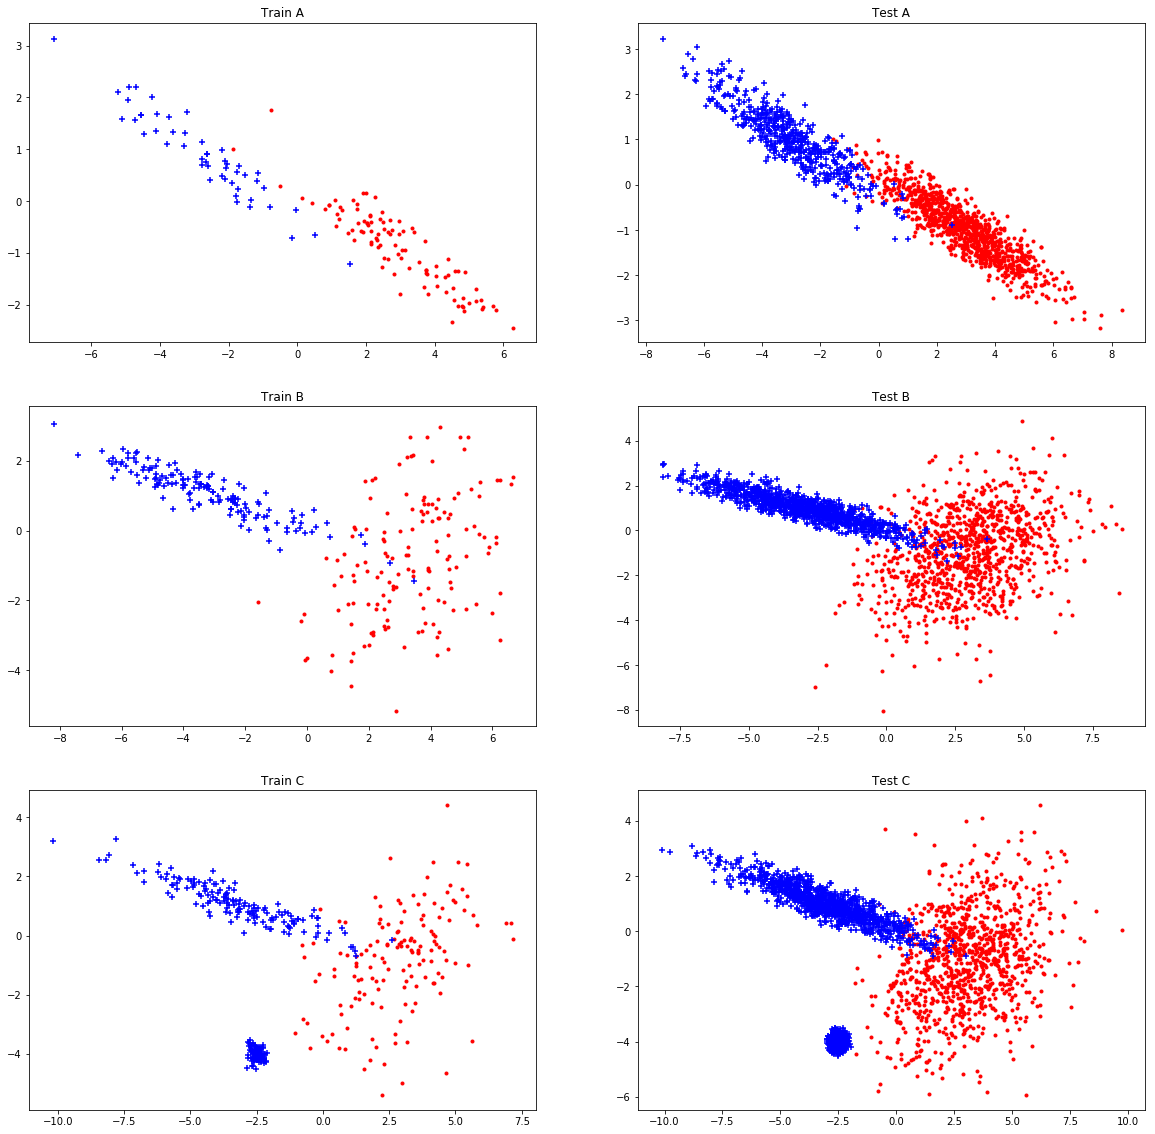

In [4]:
### Donnees artificielles, essais sur la variance des gaussiennes
plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
plot_data(XA_train,yA_train)
plt.title('Train A')

plt.subplot(3,2,2)
plot_data(XA_test,yA_test)
plt.title('Test A')

plt.subplot(3,2,3)
plot_data(XB_train,yB_train)
plt.title('Train B')

plt.subplot(3,2,4)
plot_data(XB_test,yB_test)
plt.title('Test B')

plt.subplot(3,2,5)
plot_data(XC_train,yC_train)
plt.title('Train C')

plt.subplot(3,2,6)
plot_data(XC_test,yC_test)
plt.title('Test C')

In [5]:
class Model():
    def misclassification_error(self,X,y):
        y_pred = self.predict(X)
        return np.sum(y_pred!=y)/y.shape[0]
    
    def plot_data_frontiere(self,X,y,c=0.01,step=1000):
        plt.figure(figsize=(10,10))
        self.fit(X,y)
        plot_data(X,y)
        plot_frontiere(X, self.predict, step, alpha_c=0.1)
        plt.title(self.model_name)
        

# Generative Model(LDA)

In [6]:
class LDA(Model):
    """
    Class for the LDA Model.
    We fit it with the analytical formula for maximum log-likelihood.
    """
    model_name = 'LDA'
    def fit(self,X,y):
          # Sample size and number of positive samples to compute prior pi
        n = y.shape[0]
        Ny = np.sum(y==1)
        
        self.pi = Ny/n
        
        # Compute empiric mean and covariance
        self.mu0 = np.mean(X[y==0],axis=0)
        self.mu1 = np.mean(X[y==1],axis=0)
        
        sigma_0 = (X[y==0]-self.mu0).T.dot((X[y==0]-self.mu0))/(n-Ny)
        sigma_1 = (X[y==1]-self.mu1).T.dot((X[y==1]-self.mu1))/Ny
        
        #pooled variance
        self.sigma = Ny/n*(sigma_1)  + (n-Ny)/n*(sigma_0)
        
        #Save inverse matrices and det
        self.sigma_inv = np.linalg.inv(self.sigma)
        
    def predict_proba(self,X):
        
        if X.ndim != 1:
            logp1 = np.log(self.pi) -0.5*np.apply_along_axis(lambda x:(x-self.mu1).dot(self.sigma_inv).dot((x-self.mu1).T), arr=X, axis=1)
            logp0 = np.log(1-self.pi)-0.5*np.apply_along_axis(lambda x:(x-self.mu0).dot(self.sigma_inv).dot((x-self.mu0).T), arr=X, axis=1)
            
            p1 = np.exp(logp1)
            p0 = np.exp(logp0)
            
            p1 = p1/(p0+p1)
        else:
            logp1 = np.log(self.pi) -0.5*(X-self.mu1).dot(self.sigma_inv).dot((X-self.mu1).T)
            logp0 = np.log((1-self.pi)) -0.5*(X-self.mu0).dot(self.sigma_inv).dot((X-self.mu0).T)
            
            p1 = np.exp(logp1)
            p0 = np.exp(logp0)
            
            logp1 = p1/(p0+p1)
        
        return p1

    def predict(self,X):
        return self.predict_proba(X)>0.5


In [7]:
lda = LDA()

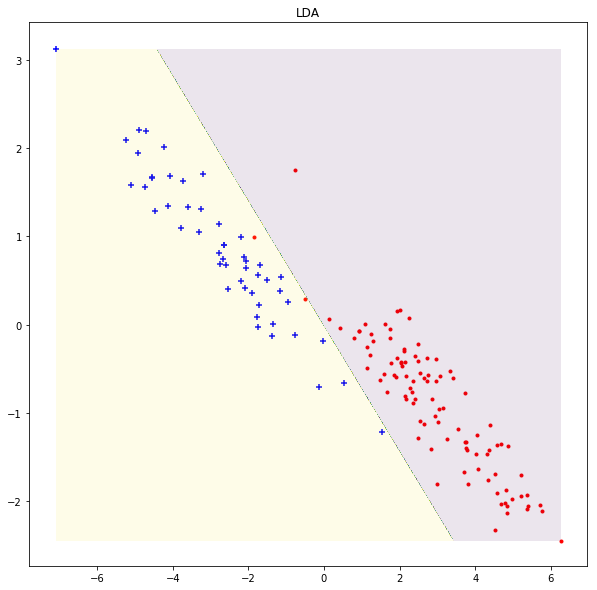

In [8]:
lda.plot_data_frontiere(XA_train, yA_train)

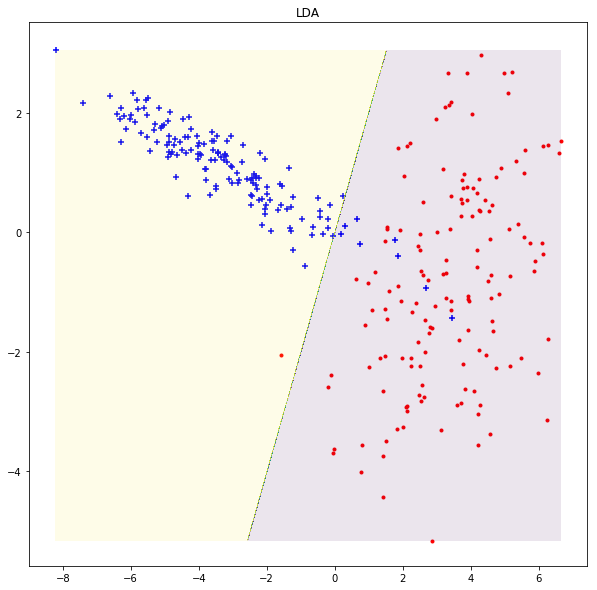

In [9]:
lda.plot_data_frontiere(XB_train, yB_train)

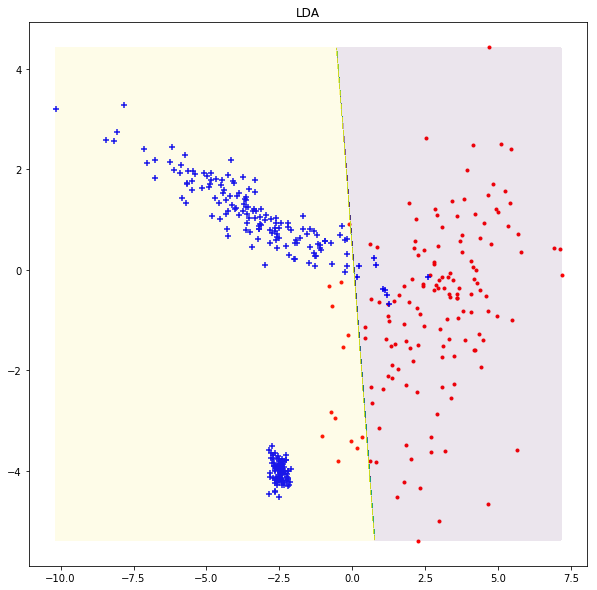

In [10]:
lda.plot_data_frontiere(XC_train, yC_train)

In [11]:
lda.fit(XA_train, yA_train)
misclass_Atrain = lda.misclassification_error(XA_train, yA_train)
misclass_Atest = lda.misclassification_error(XA_test, yA_test)

lda.fit(XB_train, yB_train)
misclass_Btrain = lda.misclassification_error(XB_train, yB_train)
misclass_Btest = lda.misclassification_error(XB_test, yB_test)

lda.fit(XC_train, yC_train)
misclass_Ctrain = lda.misclassification_error(XC_train, yC_train)
misclass_Ctest = lda.misclassification_error(XC_test, yC_test)

In [12]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.013333333333333334 0.02
0.03 0.0415
0.055 0.042333333333333334


# Logisitic regression

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [68]:
class LogisticRegression(Model):
    """
    Class for the Logistic Regression.
    We fit it using the Newton-Raphson method.
    """
    model_name = 'Logistic regression'
    
    def fit(self, X, Y, eps=1e-5):
        # Adding offset for the bias
        offset = np.ones(X.shape[0])
        offset = offset.reshape(-1,1)
        X = np.hstack((offset, X))
        
        p = X.shape[1]
        w = np.zeros(p)
        
        convergence = False
        while not(convergence):
            eta = sigmoid(X.dot(w))
            grad_w = np.dot(X.T, Y - eta)
            h_w = - X.T.dot(np.diag(eta * (1 - eta))).dot(X)
            
            convergence = (- grad_w.T.dot(np.linalg.inv(h_w)).dot(grad_w) / 2 < eps)
            if(convergence):
                break
            else:
                w = w - np.dot(np.linalg.inv(h_w), grad_w)
            
        self.w = w
        return w

    def predict_proba(self, X):
        # Adding offset for the bias
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        
        #We check the matrix dimensions to be compatible
        assert(X.shape[-1]==self.w.shape[0])
        
        return sigmoid(np.dot(X, self.w))
        
    def predict(self,X):
        return self.predict_proba(X) > 0.5

In [69]:
logreg= LogisticRegression()

In [70]:
logreg.fit(XA_train, yA_train)
misclass_Atrain = logreg.misclassification_error(XA_train, yA_train)
misclass_Atest = logreg.misclassification_error(XA_test, yA_test)

logreg.fit(XB_train, yB_train)
misclass_Btrain = logreg.misclassification_error(XB_train, yB_train)
misclass_Btest = logreg.misclassification_error(XB_test, yB_test)

logreg.fit(XC_train, yC_train)
misclass_Ctrain = logreg.misclassification_error(XC_train, yC_train)
misclass_ctest = logreg.misclassification_error(XC_test, yC_test)

/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [71]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.0 0.034
0.02 0.043
0.04 0.03833333333333333


/home/leo-alberge/.local/share/virtualenvs/TP1-jTALiYWQ/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


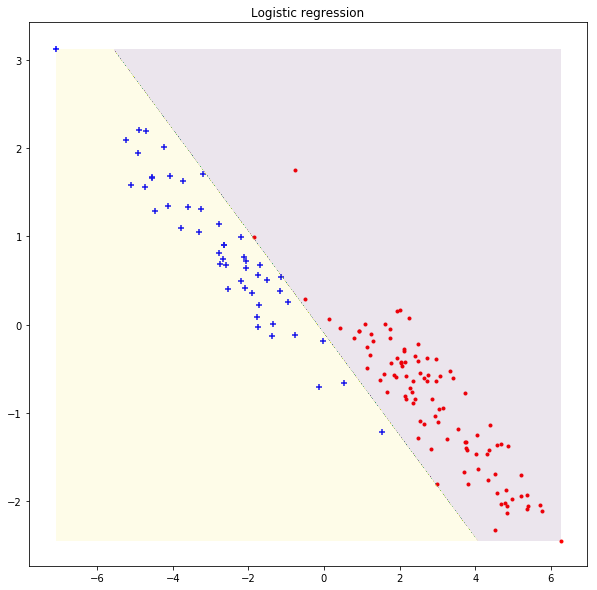

In [18]:
logreg.plot_data_frontiere(XA_train, yA_train)

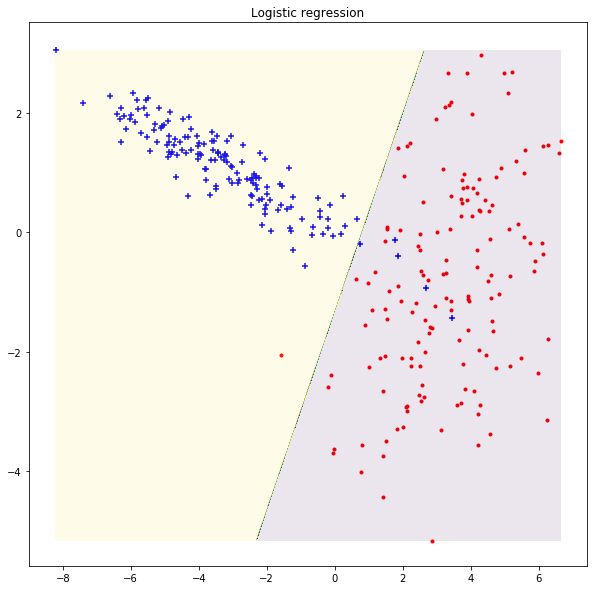

In [19]:
logreg.plot_data_frontiere(XB_train, yB_train)

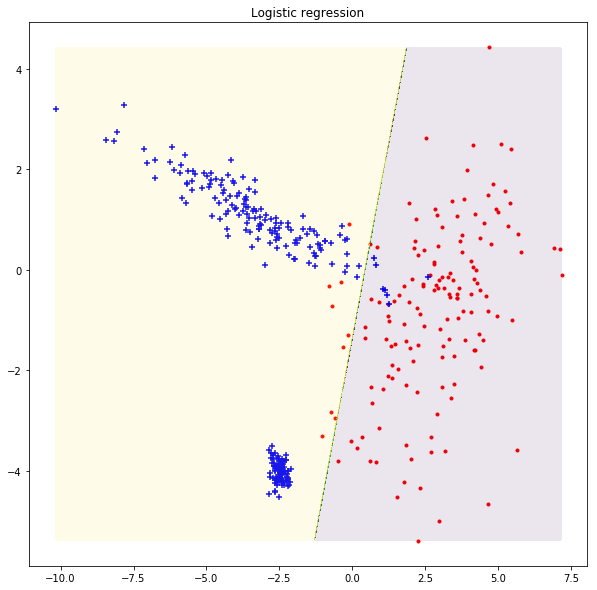

In [20]:
logreg.plot_data_frontiere(XC_train, yC_train)

# Linear Regression

In [21]:
class LinearRegression(Model):
    model_name = 'Linear Regression'
    def fit(self,X,Y):
        #we add a column of ones for the offset
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y) 
        self.w = w 
        return w

    def predict_proba(self,X, w=None):
        if w is None:
            w = self.w
        #we add a column of ones for the offset
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        #We check the matrix dimensions to be compatible
        assert(X.shape[-1]==w.shape[0])

        return X.dot(w)

    def predict(self,X, w=None):
        if w is None:
            w = self.w
        return self.predict_proba(X,w)>0.5


In [22]:
lin = LinearRegression()

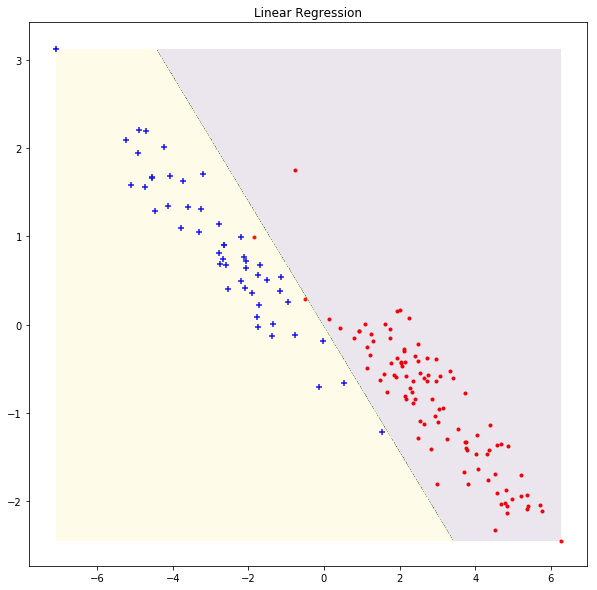

In [23]:
lin.plot_data_frontiere(XA_train, yA_train)

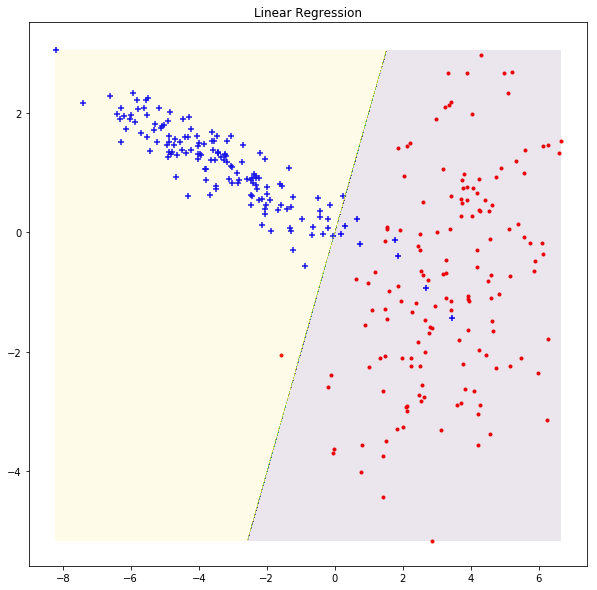

In [24]:
lin.plot_data_frontiere(XB_train, yB_train)

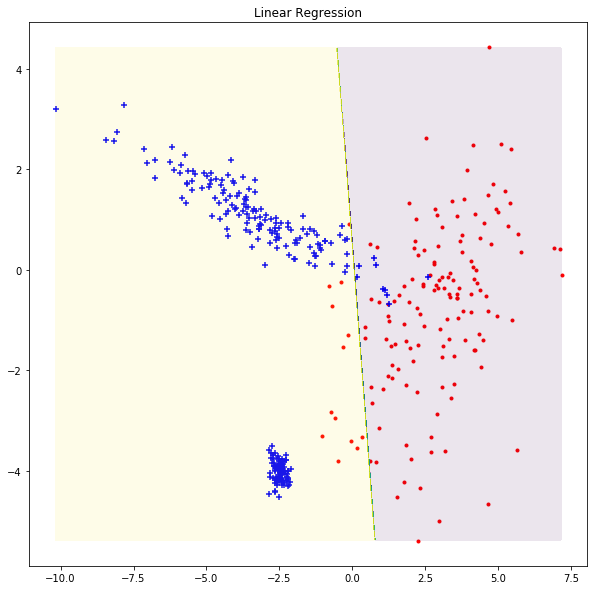

In [25]:
lin.plot_data_frontiere(XC_train, yC_train)

In [26]:
lin.fit(XA_train, yA_train)
misclass_Atrain = lda.misclassification_error(XA_train, yA_train)
misclass_Atest = lda.misclassification_error(XA_test, yA_test)

lin.fit(XB_train, yB_train)
misclass_Btrain = lda.misclassification_error(XB_train, yB_train)
misclass_Btest = lda.misclassification_error(XB_test, yB_test)

lin.fit(XC_train, yC_train)
misclass_Ctrain = lda.misclassification_error(XC_train, yC_train)
misclass_Ctest = lda.misclassification_error(XC_test, yC_test)

In [27]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.03333333333333333 0.027333333333333334
0.04666666666666667 0.066
0.055 0.042333333333333334


In [28]:
X= np.random.rand(100,2)

# QDA 

In [29]:
class QDA(Model):
    """
    Class for the QDA Model.
    We fit it with the analytical formula for the maximum log-likelihood.
    """
    model_name = 'QDA'
    
    def fit(self,X,y):
        # Sample size and number of positive samples to compute prior pi
        n = y.shape[0]
        Ny = np.sum(y==1)
        
        self.pi = Ny/n
        
        # Compute empiric mean and covariance
        self.mu0 = np.mean(X[y==0],axis=0)
        self.mu1 = np.mean(X[y==1],axis=0)
        
        self.sigma_0 = (X[y==0]-self.mu0).T.dot((X[y==0]-self.mu0))/(n-Ny)
        self.sigma_1 = (X[y==1]-self.mu1).T.dot((X[y==1]-self.mu1))/Ny
        
        #Save inverse matrices and det
        self.sigma0_inv = np.linalg.inv(self.sigma_0)
        self.sigma1_inv = np.linalg.inv(self.sigma_1)
        
        self.sigma0_det = np.linalg.det(self.sigma_0)
        self.sigma1_det = np.linalg.det(self.sigma_1)
     
        
    def predict_proba(self,X):
        # Predict proba for samples
        if X.ndim != 1:
            logp1 = np.log(self.pi) -0.5*np.log(self.sigma1_det) -0.5*np.apply_along_axis(lambda x:(x-self.mu1).dot(self.sigma1_inv).dot((x-self.mu1).T), arr=X, axis=1)
            logp0 = np.log(1-self.pi)-0.5*np.log(self.sigma0_det) -0.5*np.apply_along_axis(lambda x:(x-self.mu0).dot(self.sigma0_inv).dot((x-self.mu0).T), arr=X, axis=1)
            
            p1 = np.exp(logp1)
            p0 = np.exp(logp0)
            
            p1 = p1/(p0+p1)
        #Predict proba for a sample
        else:
            logp1 = np.log(self.pi)-0.5*np.log(self.sigma1_det) -0.5*(X-self.mu1).dot(self.sigma1_inv).dot((X-self.mu1).T)
            logp0 = np.log((1-self.pi)) -0.5*np.log(self.sigma0_det)-0.5*(X-self.mu0).dot(self.sigma0_inv).dot((X-self.mu0).T)
            
            p1 = np.exp(logp1)
            p0 = np.exp(logp0)
            
            logp1 = p1/(p0+p1)
        
        return p1
    
    def predict(self,X):
        ## Assign to class 1 if the probability of the class 1 is greater than 0.5
        return self.predict_proba(X)>0.5


In [30]:
qad = QDA()

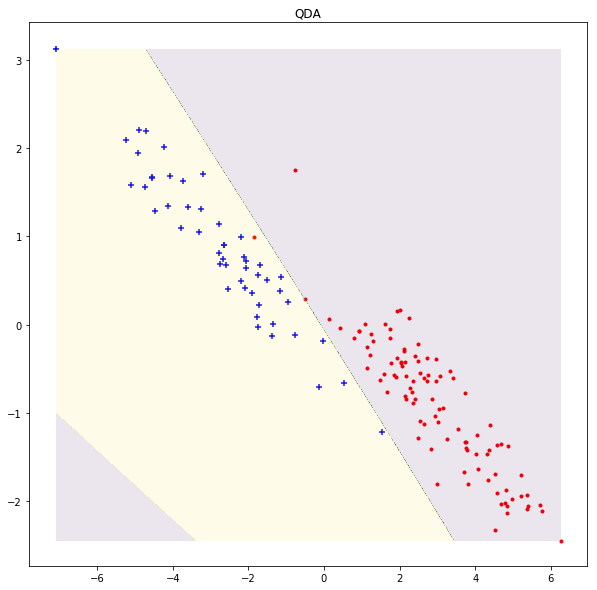

In [31]:
qad.plot_data_frontiere(XA_train, yA_train)

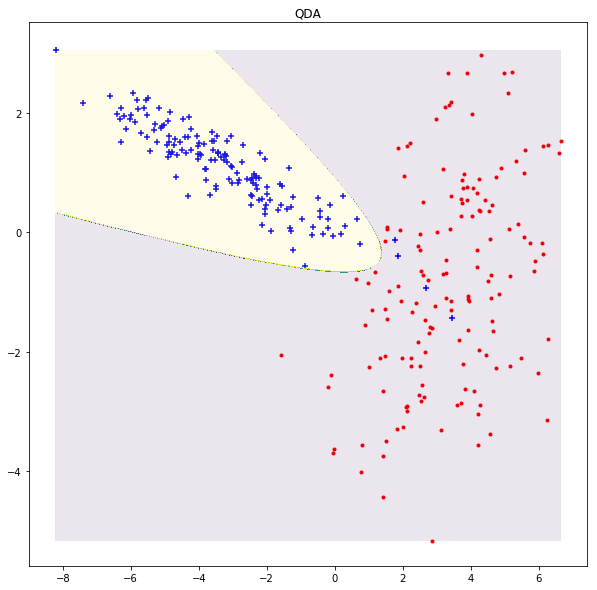

In [32]:
qad.plot_data_frontiere(XB_train, yB_train)

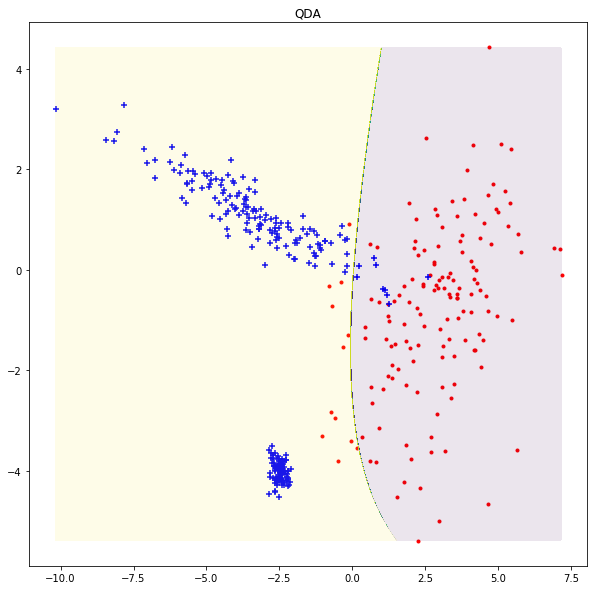

In [33]:
qad.plot_data_frontiere(XC_train, yC_train)

In [34]:
qad.fit(XA_train, yA_train)
misclass_Atrain = qad.misclassification_error(XA_train, yA_train)
misclass_Atest = qad.misclassification_error(XA_test, yA_test)

qad.fit(XB_train, yB_train)
misclass_Btrain = qad.misclassification_error(XB_train, yB_train)
misclass_Btest = qad.misclassification_error(XB_test, yB_test)

qad.fit(XC_train, yC_train)
misclass_Ctrain = qad.misclassification_error(XC_train, yC_train)
misclass_Ctest = qad.misclassification_error(XC_test, yC_test)

In [35]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.006666666666666667 0.02
0.013333333333333334 0.02
0.0525 0.03833333333333333
